## Homework: Agents

In this homework, we will learn more about function calling,
and we will also explore MCP - model-context protocol. 

## Preparation

First, we'll define a function that we will use when building
our agent. 

It will generate fake weather data:

```python
import random

known_weather_data = {
    'berlin': 20.0
}

def get_weather(city: str) -> float:
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)
```


In [1]:
import random

known_weather_data = {
    'berlin': 20.0
}

def get_weather(city: str) -> float:
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)

## Q1. Define function description

We want to use it as a tool for our agent, so we need to 
describe it 

How should the description for this function look like? Fill in missing parts

```python
get_weather_tool = {
    "type": "function",
    "name": "<TODO1>",
    "description": "<TODO2>",
    "parameters": {
        "type": "object",
        "properties": {
            "<TODO3>": {
                "type": "string",
                "description": "<TODO4>"
            }
        },
        "required": [TODO5],
        "additionalProperties": False
    }
}
```

What did you put in `TODO3`?




## Testing it (Optional)

If you have OpenAI API Key (or alternative provider),
let's test it.

A question could be "What's the weather like in Germany?"

Experiment with different system prompts to have better answers
from the system.

You can use [chat_assistant.py](https://github.com/alexeygrigorev/rag-agents-workshop/blob/main/chat_assistant.py)
or implement everything yourself 

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/rag-agents-workshop/refs/heads/main/chat_assistant.py
```

In [7]:
get_weather_tool = {
    "type": "function",
    "name": "get_weather",
    "description": "Search the FAQ database",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {
                "type": "string",
                "description": "Search city text to look up in the weather FAQ."
            }
        },
        "required": ["query"],
        "additionalProperties": False
    }
}

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/rag-agents-workshop/refs/heads/main/chat_assistant.py

--2025-07-14 11:21:05--  https://raw.githubusercontent.com/alexeygrigorev/rag-agents-workshop/refs/heads/main/chat_assistant.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3485 (3.4K) [text/plain]
Saving to: ‘chat_assistant.py.2’

chat_assistant.py.2 100%[===================>]   3.40K  --.-KB/s    in 0s      

2025-07-14 11:21:05 (13.0 MB/s) - ‘chat_assistant.py.2’ saved [3485/3485]



In [29]:
import chat_assistant

In [30]:
tools = chat_assistant.Tools()
tools.add_tool(get_weather, get_weather_tool)

In [31]:
tools.get_tools()

[{'type': 'function',
  'name': 'get_weather',
  'description': 'Search the FAQ database',
  'parameters': {'type': 'object',
   'properties': {'city': {'type': 'string',
     'description': 'Search query text to look up in the course FAQ.'}},
   'required': ['query'],
   'additionalProperties': False}}]

In [32]:
from openai import OpenAI
client = OpenAI()

In [33]:
question = "What's the weather like in Germany?"

In [34]:
developer_prompt = """
You are a weather assistant for countries and cities.
Someone has asked you a question, and your task is to answer it.

Use the FAQ if your knowledge isn't sufficient to answer it.

At the end of each answer, ask the user a follow-up question based on your response.
""".strip()

chat_interface = chat_assistant.ChatInterface()

chat = chat_assistant.ChatAssistant(
    tools=tools,
    developer_prompt=developer_prompt,
    chat_interface=chat_interface,
    client=client
)

In [35]:
chat.run()

You: What's the weather like in Germany?


You: stop


Chat ended.


## Q2. Adding another tool

Let's add another tool - a function that can add weather data
to our database:

```python
def set_weather(city: str, temp: float) -> None:
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'
```

Now let's write a description for it.

What did you write?

Optionally, you can test it after adding this function.


In [38]:
def set_weather(city: str, temp: float) -> None:
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'

In [39]:
set_weather_tool = {
    "type": "function",
    "name": "set_weather",
    "description": "Add specific city temperature in the weather database",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {
                "type": "string",
                "description": "City text to be added to the weather data."
            },
            "temp": {
                "type": "string",
                "description": "City temperature to be added to the weather data."
            }
        },
        "required": ["city", "temp"],
        "additionalProperties": False
    }
}

In [40]:
tools.add_tool(set_weather, set_weather_tool)

In [41]:
tools.get_tools()

[{'type': 'function',
  'name': 'get_weather',
  'description': 'Search the FAQ database',
  'parameters': {'type': 'object',
   'properties': {'city': {'type': 'string',
     'description': 'Search query text to look up in the course FAQ.'}},
   'required': ['query'],
   'additionalProperties': False}},
 {'type': 'function',
  'name': 'set_weather',
  'description': 'Add specific city temperature in the weather database',
  'parameters': {'type': 'object',
   'properties': {'city': {'type': 'string',
     'description': 'City text to be added to the weather data.'},
    'temp': {'type': 'string',
     'description': 'City temperature to be added to the weather data.'}},
   'required': ['city', 'temp'],
   'additionalProperties': False}}]

## MCP

MCP stands for Model-Context Protocol. It allows LLMs communicate
with different tools (like Qdrant). It's function calling, but 
one step further:

* A tool can export a list of functions it has
* When we include the tool to our Agent, we just need to include the link to the MCP server

## Q3. Install FastMCP

Let's install a library for MCP - [FastMCP](https://github.com/jlowin/fastmcp):

```bash
pip install fastmcp
```

What's the version of FastMCP you installed?

In [36]:
import fastmcp

In [37]:
fastmcp.__version__

'2.10.5'

## Q4. Simple MCP Server 

A simple MCP server from the documentation looks like that:

```python
# weather_server.py
from fastmcp import FastMCP

mcp = FastMCP("Demo 🚀")

@mcp.tool
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

if __name__ == "__main__":
    mcp.run()
```

In our case, we need to write docstrings for our functions.

Let's ask ChatGPT for help:

```python
def get_weather(city: str) -> float:
    """
    Retrieves the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to retrieve weather data.

    Returns:
        float: The temperature associated with the city.
    """
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)


def set_weather(city: str, temp: float) -> None:
    """
    Sets the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to set the weather data.
        temp (float): The temperature to associate with the city.

    Returns:
        str: A confirmation string 'OK' indicating successful update.
    """
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'
```

Let's change the example for our case and run it

What do you see in the output?

Look for a string that matches this template:

```
Starting MCP server 'Demo 🚀' with transport '<TODO>'
```

What do you have instead of `<TODO>`?

In [10]:
%%writefile weather_server.py
from fastmcp import FastMCP
import random

# Diccionario para almacenar los datos de clima conocidos (puede ser una base de datos en producción)
known_weather_data = {
    'berlin': 20.0
}

mcp = FastMCP("Demo 🚀")

@mcp.tool
def get_weather(city: str) -> float:
    """
    Retrieves the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to retrieve weather data.

    Returns:
        float: The temperature associated with the city.
    """
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)


@mcp.tool
def set_weather(city: str, temp: float) -> str:
    """
    Sets the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to set the weather data.
        temp (float): The temperature to associate with the city.

    Returns:
        str: A confirmation string 'OK' indicating successful update.
    """
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'


if __name__ == "__main__":
    mcp.run()

Overwriting weather_server.py


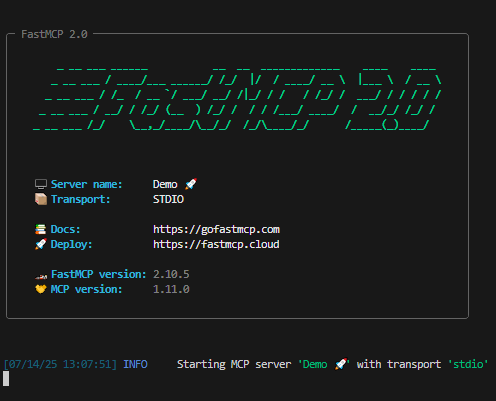

**STDIO**

## Q5. Protocol

There are different ways to communicate with an MCP server.
Ours is currently running using standart input/output, which
means that the client write something to stdin and read the
answer using stdout.

Our weather server is currently running.

This is how we start communitcating with it:

- First, we send an initialization request -- this way, we register our client with the server:
    ```json
    {"jsonrpc": "2.0", "id": 1, "method": "initialize", "params": {"protocolVersion": "2024-11-05", "capabilities": {"roots": {"listChanged": true}, "sampling": {}}, "clientInfo": {"name": "test-client", "version": "1.0.0"}}}
    ```
    We should get back something like that, which is an aknowledgement of the request:
    ```json
    {"jsonrpc":"2.0","id":1,"result":{"protocolVersion":"2024-11-05","capabilities":{"experimental":{},"prompts":{"listChanged":false},"resources":{"subscribe":false,"listChanged":false},"tools":{"listChanged":true}},"serverInfo":{"name":"Demo 🚀","version":"1.9.4"}}}
    ```
-  Next, we reply back, confirming the initialization:
    ```json
    {"jsonrpc": "2.0", "method": "notifications/initialized"}
    ```
    We don't expect to get anything in response
- Now we can ask for a list of available methods:
    ```json
    {"jsonrpc": "2.0", "id": 2, "method": "tools/list"}
    ```
- Let's ask the temperature in Berlin:
    ```json
    {"jsonrpc": "2.0", "id": 3, "method": "tools/call", "params": {"name": "<TODO>", "arguments": {<TODO>}}}
    ```
- What did you get in response?


```json
{"jsonrpc": "2.0", "id": 3, "method": "tools/call", "params": {"name": "get_weather", "arguments": {"city": "Berlin"}}}
```

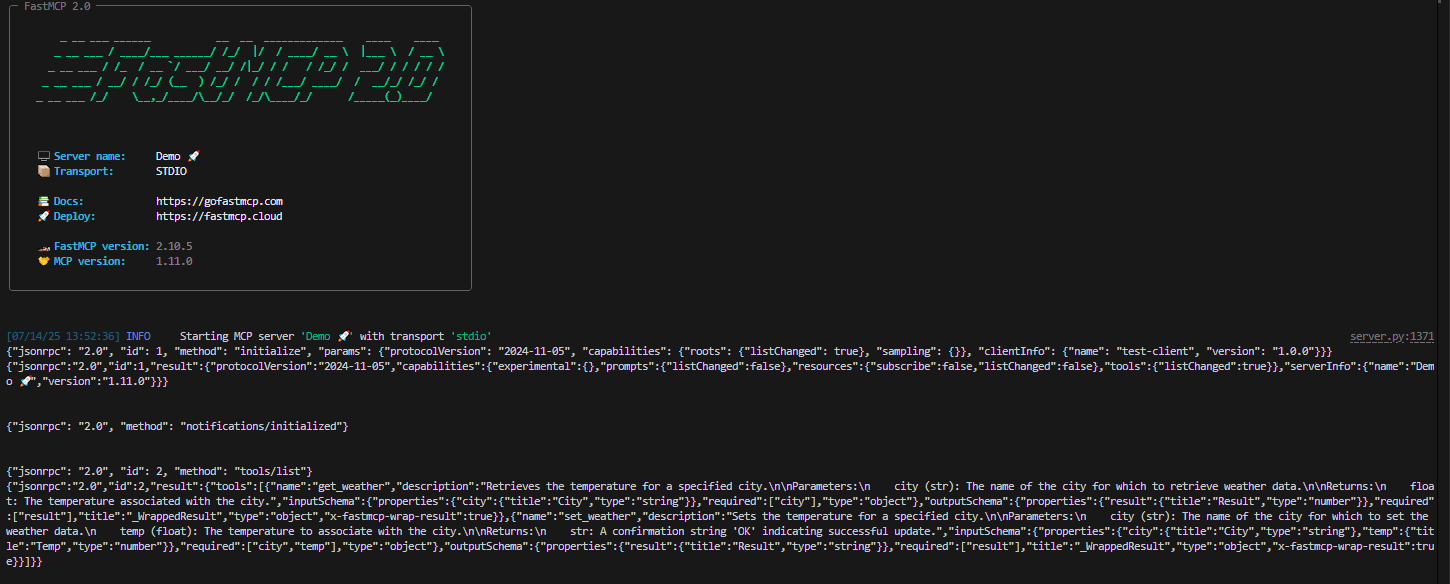

```json
{"jsonrpc": "2.0", "id": 1, "method": "initialize", "params": {"protocolVersion": "2024-11-05", "capabilities": {"roots": {"listChanged": true}, "sampling": {}}, "clientInfo": {"name": "test-client", "version": "1.0.0"}}}
{"jsonrpc":"2.0","id":1,"result":{"protocolVersion":"2024-11-05","capabilities":{"experimental":{},"prompts":{"listChanged":false},"resources":{"subscribe":false,"listChanged":false},"tools":{"listChanged":true}},"serverInfo":{"name":"Demo 🚀","version":"1.11.0"}}}


{"jsonrpc": "2.0", "method": "notifications/initialized"}


{"jsonrpc": "2.0", "id": 2, "method": "tools/list"}
{"jsonrpc":"2.0","id":2,"result":{"tools":[{"name":"get_weather","description":"Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.","inputSchema":{"properties":{"city":{"title":"City","type":"string"}},"required":["city"],"type":"object"},"outputSchema":{"properties":{"result":{"title":"Result","type":"number"}},"required":["result"],"title":"_WrappedResult","type":"object","x-fastmcp-wrap-result":true}},{"name":"set_weather","description":"Sets the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to set the weather data.\n    temp (float): The temperature to associate with the city.\n\nReturns:\n    str: A confirmation string 'OK' indicating successful update.","inputSchema":{"properties":{"city":{"title":"City","type":"string"},"temp":{"title":"Temp","type":"number"}},"required":["city","temp"],"type":"object"},"outputSchema":{"properties":{"result":{"title":"Result","type":"string"}},"required":["result"],"title":"_WrappedResult","type":"object","x-fastmcp-wrap-result":true}}]}}


{"jsonrpc": "2.0", "id": 3, "method": "tools/call", "params": {"name": "get_weather", "arguments": {"city": "Berlin"}}}
{"jsonrpc":"2.0","id":3,"result":{"content":[{"type":"text","text":"20.0"}],"structuredContent":{"result":20.0},"isError":false}}
```

**20.0**

## Q6. Client

We typically don't interact with the server by copy-pasting 
commands in the terminal.

In practice, we use an MCP Client. Let's implement it. 

FastMCP also supports MCP clients:

```python
from fastmcp import Client

async def main():
    async with Client(<TODO>) as mcp_client:
        # TODO
```

Use the client to get the list of available tools
of our script. How does the result look like?

If you're running this code in Jupyter, you need to pass
an instance of MCP server to the `Client`:

```python
import weather_server

async def main():
    async with Client(weather_server.mcp) as mcp_client:
        # ....
```

If you run it in a script, you will need to use asyncio:

```python
import asyncio

async def main():
    async with Client("weather_server.py") as mcp_client:
        # ...

if __name__ == "__main__":
    test = asyncio.run(main())
```

Copy the output with the available tools when
filling in the homework form.

In [24]:
%%writefile weather_client.py
from fastmcp import Client
import asyncio

async def main():
    async with Client("weather_server.py") as mcp_client:
        tools = await mcp_client.list_tools()
        print(f"Available tools: {tools}")

if __name__ == "__main__":
    test = asyncio.run(main())
    print(test)

Overwriting weather_client.py


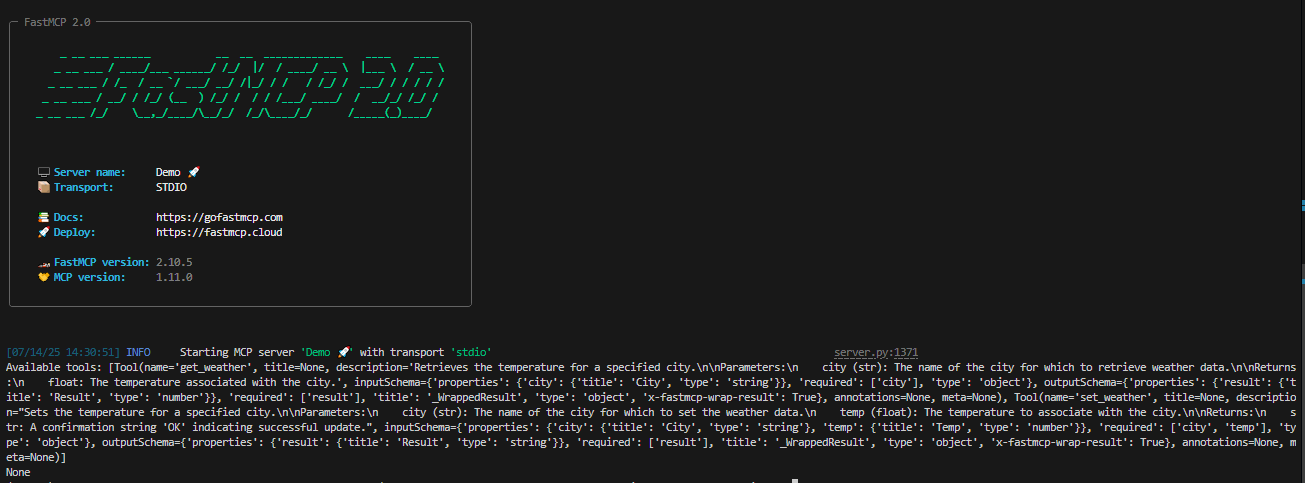

```plaintext
Available tools: [Tool(name='get_weather', title=None, description='Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.', inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}}, 'required': ['city'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'number'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta=None), Tool(name='set_weather', title=None, description="Sets the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to set the weather data.\n    temp (float): The temperature to associate with the city.\n\nReturns:\n    str: A confirmation string 'OK' indicating successful update.", inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}, 'temp': {'title': 'Temp', 'type': 'number'}}, 'required': ['city', 'temp'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'string'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta=None)]
None
```

## Using tools from the MCP server (optional)

FastMCP uses asyncio for client-server communication. In our
case, the code we wrote previously in the module
(chat_assistant.py) is not asyncio-friendly, so it will
require a lot of adjustments to run it. 

Which is why we asked Claude to implement a simple
non-async MCP client (see [mcp_client.py](mcp_client.py))
that can only do this:

- List tools
- Invoke the specified tool

Note: this is not a production-ready MCP Client! Use it
only for learning purposes.

Check the code - it's quite illustrative. Or experiment
with writing this code yourself.

Here's how we can use it:

```python
import mcp_client

our_mcp_client = mcp_client.MCPClient(["python", "weather_server.py"])

our_mcp_client.start_server()
our_mcp_client.initialize()
our_mcp_client.initialized()
```

While it's somewhat verbose, it follows
the initialization structure we outlined in Q5.

Now we can use it:

```python
our_mcp_client.get_tools()
our_mcp_client.call_tool('get_weather', {'city': 'Berlin'})
```

In order to include it in our existing application, we need
a wrapper class:

```python
import json

class MCPTools:
    def __init__(self, mcp_client):
        self.mcp_client = mcp_client
        self.tools = None
    
    def get_tools(self):
        if self.tools is None:
            mcp_tools = self.mcp_client.get_tools()
            self.tools = convert_tools_list(mcp_tools)
        return self.tools

    def function_call(self, tool_call_response):
        function_name = tool_call_response.name
        arguments = json.loads(tool_call_response.arguments)

        result = self.mcp_client.call_tool(function_name, arguments)

        return {
            "type": "function_call_output",
            "call_id": tool_call_response.call_id,
            "output": json.dumps(result, indent=2),
        }
```

It's very similar to the `Tools` class we created in the
module, but it uses MCP to communicate with the MCP Server.

(Where `convert_tools_list` converts MCP functions description
format into the OpenAI's one)

Let's use it:

```python
our_mcp_client = mcp_client.MCPClient(["python", "weather_server.py"])

our_mcp_client.start_server()
our_mcp_client.initialize()
our_mcp_client.initialized()

mcp_tools = mcp_client.MCPTools(mcp_client=our_mcp_client)


developer_prompt = """
You help users find out the weather in their cities. 
If they didn't specify a city, ask them. Make sure we always use a city.
""".strip()

chat_interface = chat_assistant.ChatInterface()

chat = chat_assistant.ChatAssistant(
    tools=mcp_tools,
    developer_prompt=developer_prompt,
    chat_interface=chat_interface,
    client=client
)

chat.run()
```

Now we use the MCP server for function calling!



## Submit the results

* Submit your results here: https://courses.datatalks.club/llm-zoomcamp-2025/homework/agents